## Simulation generator for XClone

Install xclone for using the `CNV_simulator` function in `xclone/simulator.py`

In [1]:
import numpy as np
from scipy.sparse import load_npz
from xclone.simulator import CNV_ASE_simulator

In [2]:
dat_dir = "./"

### Load G&T data

In [4]:
# DP_RNA = load_npz(dat_dir + "/scRNA_DP.npz").toarray()
# DP_DNA = load_npz(dat_dir + "/scDNA_DP.npz").toarray()

DP_RNA = load_npz(dat_dir + "../data/G_T/scRNA/block_DP.npz").toarray()
DP_DNA = load_npz(dat_dir + "../data/G_T/scDNA/block_DP.npz").toarray()

print(DP_RNA.shape, DP_DNA.shape)
print(DP_DNA)
print(DP_RNA)

(10152, 89) (10152, 89)
[[188. 346. 181. ...  37.  66.  58.]
 [ 43.  75.  67. ...  17.  32.  22.]
 [  1.   3.  nan ...   2.  nan  nan]
 ...
 [ 15.  10.  18. ...   2.  11.   6.]
 [  5.   4.   5. ...   1.  nan  nan]
 [ 75.  87. 149. ...  28.  39.  16.]]
[[ 6.  7. 10. ... 85. 10. 84.]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]]


In [5]:
DP_RNA[DP_RNA != DP_RNA] = 0
DP_DNA[DP_DNA != DP_DNA] = 0

### Example simulation

In [6]:
n_clone = 4
n_block = 100
tau_fix = np.array([[0, 1], [1, 2], [1, 1], [2, 1], [1, 0]])
T_mat_rand = np.random.choice(range(5), size=(n_block, n_clone))

simu_dat = CNV_ASE_simulator(tau_fix, T_mat_rand, 
                             DP_RNA[:n_block, :], 
                             DP_DNA[:n_block, :],
                             share_theta=False,
                             n_cell_DNA=150, n_cell_RNA=200,
                             random_seed=2)

In [7]:
simu_dat.keys()

dict_keys(['tau', 'T_mat', 'I_RNA', 'I_DNA', 'X_RNA', 'X_DNA', 'DP_RNA', 'DP_DNA', 'AD_RNA', 'AD_DNA', 'Theta_RNA', 'Theta_DNA'])

In [8]:
print(np.unique(simu_dat['I_RNA'], return_counts=True),
      np.unique(simu_dat['I_DNA'], return_counts=True))

(array([0, 1, 2, 3]), array([45, 42, 57, 56])) (array([0, 1, 2, 3]), array([37, 44, 29, 40]))


#### Run Vireo

In [9]:
import vireoSNP
from scipy import sparse

# np.random.seed(2)

theta_prior = np.array([[0.01, 1], [1, 2], [1, 1], [2, 1], [1, 0.01]])

AD = sparse.csr_matrix(np.append(simu_dat['AD_RNA'], 
                                 simu_dat['AD_DNA'], axis=1))
DP = sparse.csr_matrix(np.append(simu_dat['DP_RNA'], 
                                 simu_dat['DP_DNA'], axis=1))

### with multiple initializations
## CNV block specific allelic ratio can be used by add ASE_mode=True
res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
                           n_extra_donor=0, #ASE_mode=True,
                           theta_prior=theta_prior, learn_theta=True, 
                           n_init=50, check_doublet=False, random_seed=1)

## with single initialization
# res = vireoSNP.vireo_flock(AD, DP, n_donor=4, learn_GT=True,
#                           theta_prior=theta_prior, learn_theta=True, 
#                           check_doublet=False)#, ASE_mode=False)

print("Output donor size:", res['ID_prob'].sum(axis=0))

[vireo] warm-up: 50 random initializations for 4 clusters...
donor2	donor0	donor1	donor3
95	84	85	86
[vireo] warm-up: lower bound ranges [-609389.9, -516621.4, -516621.4]
[vireo] main RUN with warm initials and tuned GT ...
[vireo] main RUN: 22 iterations; lower bound -516621.4
[vireo] beta parameters for binomial rate:
[[1327.5 227114.1]
 [68020.7 177448.3]
 [195641.8 181743.5]
 [106409.3 41709.4]
 [215062.7 2884.7]]
Output donor size: [94.5 84.1 85.2 86.2]


In [10]:
from sklearn.metrics import adjusted_rand_score

print(adjusted_rand_score(np.argmax(res['ID_prob'], axis=1)[:200], simu_dat['I_RNA']))
print(adjusted_rand_score(np.argmax(res['ID_prob'], axis=1)[200:], simu_dat['I_DNA']))

0.9455299170439057
1.0


### Plot simulation results

In [11]:
def anno_heat(X, anno, **kwargs):
    WeiZhu_colors = np.array(['#4796d7', '#f79e54', '#79a702', '#df5858', '#556cab', 
                 '#de7a1f', '#ffda5c', '#4b595c', '#6ab186', '#bddbcf', 
                 '#daad58', '#488a99', '#f79b78', '#ffba00'])
    
    idx = np.argsort(np.dot(X, 2**np.arange(X.shape[1])) + 
                     anno * 2**X.shape[1])
    g = sns.clustermap(X[idx], cmap="GnBu", yticklabels=False,
                       col_cluster=False, row_cluster=False,
                       row_colors=WeiZhu_colors[anno][idx], **kwargs)
    
    for label in np.unique(anno):
        g.ax_col_dendrogram.bar(0, 0, color=WeiZhu_colors[label],
                                label=label, linewidth=0)
    g.ax_col_dendrogram.legend(loc="center", ncol=6, title="True clone")
    g.cax.set_position([.95, .2, .03, .45])

    return g

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

im = anno_heat(res['ID_prob'][:200], np.array(simu_dat['I_RNA'], int))
im.ax_heatmap.set(xlabel='infered clones', 
                  ylabel='200 cells',
                  title='scRNSA-seq: Adj Rand Index=%.3f' 
                  %(adjusted_rand_score(np.argmax(res['ID_prob'], axis=1)[:200], 
                                        simu_dat['I_RNA'])))

[Text(308.364,0.5,'200 cells'),
 Text(0.5,80.7222,'infered clones'),
 Text(0.5,1,'scRNSA-seq: Adj Rand Index=0.946')]

[Text(222.022,0.5,'150 cells'),
 Text(0.5,69,'infered clones'),
 Text(0.5,1,'scDNSA-seq: Adj Rand Index=1.000')]

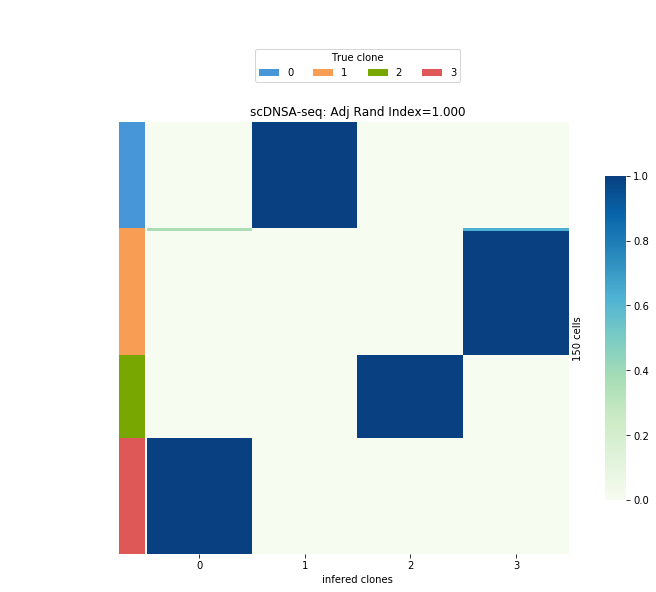

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

im = anno_heat(res['ID_prob'][200:], np.array(simu_dat['I_DNA'], int))
im.ax_heatmap.set(xlabel='infered clones', 
                  ylabel='150 cells',
                  title='scDNSA-seq: Adj Rand Index=%.3f' 
                  %(adjusted_rand_score(np.argmax(res['ID_prob'], axis=1)[200:], 
                                        simu_dat['I_DNA'])))

[Text(183.556,0.5,'CNV blocks'),
 Text(0.5,69,'infered clones'),
 Text(0.5,1,'Allele ratio')]

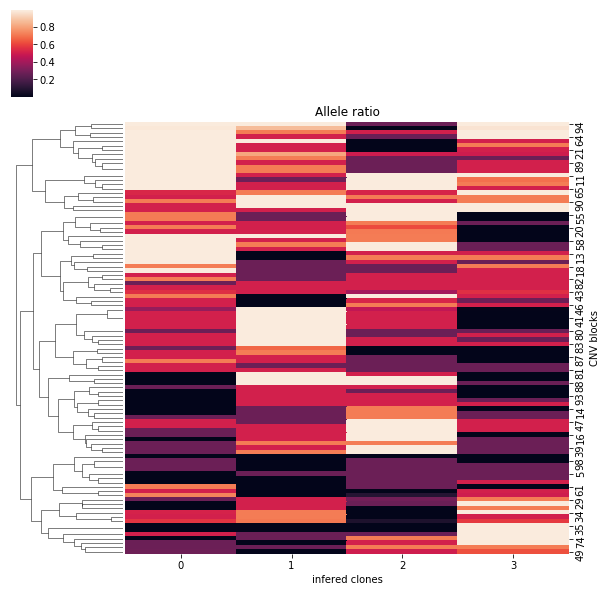

In [14]:
_theta = res['theta_shapes'][:, 0] / res['theta_shapes'].sum(axis=1)
_theta_clone = np.tensordot(res['GT_prob'], _theta, axes=[1,0])

im = sns.clustermap(_theta_clone, col_cluster=False)
im.ax_heatmap.set(xlabel='infered clones', 
                  ylabel='CNV blocks',
                  title='Allele ratio')

[Text(183.556,0.5,'CNV blocks'),
 Text(0.5,69,'200 cells'),
 Text(0.5,1,'log10(DP) scRNA-seq')]

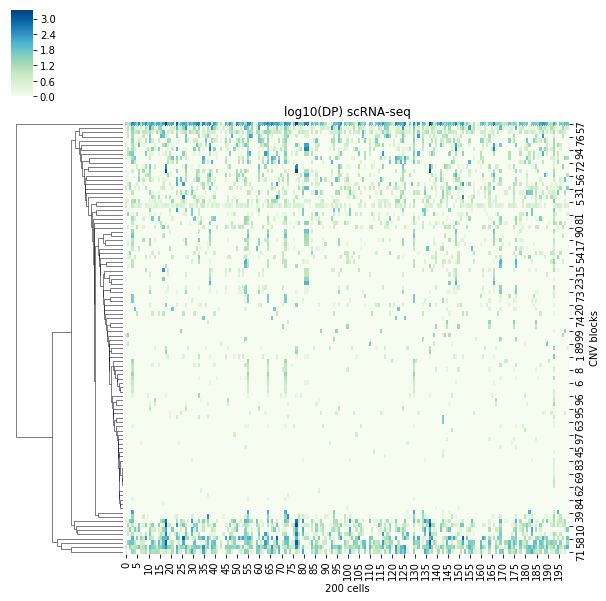

In [15]:
im = sns.clustermap(np.log10(simu_dat['DP_RNA'] + 1), 
                    col_cluster=False, cmap='GnBu')
im.ax_heatmap.set(xlabel='200 cells', 
                  ylabel='CNV blocks',
                  title='log10(DP) scRNA-seq')

[Text(183.556,0.5,'CNV blocks'),
 Text(0.5,69,'150 cells'),
 Text(0.5,1,'log10(DP) scDNA-seq')]

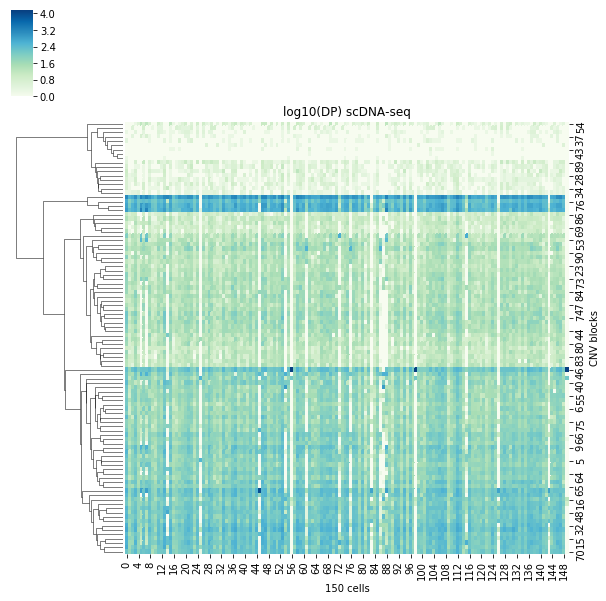

In [16]:
im = sns.clustermap(np.log10(simu_dat['DP_DNA'] + 1), 
                    col_cluster=False, cmap='GnBu')
im.ax_heatmap.set(xlabel='150 cells', 
                  ylabel='CNV blocks',
                  title='log10(DP) scDNA-seq')

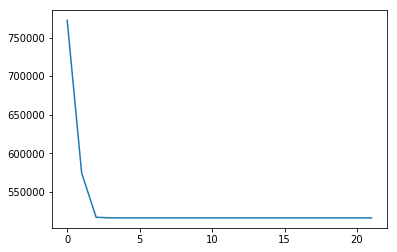

In [17]:
plt.plot(-res['LB_list'])
plt.show()